# **UNDERSTANDING REJECTED LOAN APPLICATION ON LENDING CLUB DATA**

## Introduction


### **Definition**
LendingClub is a financial peer-to-peer lending services company headquartered in San Francisco.
LendingClub enabled borrowers to create unsecured personal loans between 1,000 and $40,000. The standard loan period was three years. In finance, unsecured debt refers to any type of debt or general obligation that is not protected by a guarantor. Lender (Peers who give the money to the borrower ) are able to search and browse the loan listings on LendingClub website and select loans that they wanted to invest in based on the information supplied about the borrower. Investors made money from the interest on these loans. LendingClub made money by charging borrowers an origination fee and investors a service fee.

\
But before an individual can published a request for a loan, his demand will be examine by Lending Club to evaluate if the demand is credible or not. Thus we got accepted and rejected loan application.

\

### **Objective**


Our objective is to perform Topic Modeling and then Clustering on rejected loan application to understand why they have been rejected and help borrowers improve their applications !

\
### **Dataset**

We will be using the rejected loan application (between 2007 and 2018) dataset originated from LendingClub, gathered by Nathan George on Kaggle:
\
rejected_2007_to_2018Q4.csv.gz
https://www.kaggle.com/datasets/wordsforthewise/lending-club

\
The Dataset contain the following features:

1. **amount_requested**: The amount requested by the borrower.
2. **application_date**: Date of the loan application.
3. **loan_title**: The nature or purpose of the loan.
4. **risk_score**: The risk associated with the borrower.
5. **debt_to_income_ratio**: The ratio between the borrower’s debt and income.
6. **zip_code**: The postal zip code of the borrower.
7. **state**: The state of residence of the borrower.
8. **employment_length**: The number of years the borrower has been employed.
9. **policy_code**: Code representing the policy under which the loan was requested.

## EDA : Load, Clean, Represent and Analyse the Data

### Load the dataset

In [92]:
#Mount Google Colab drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [147]:
#Import necessary libraries
import re
import gzip
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [94]:
#Open the file
with gzip.open('/content/drive/MyDrive/UML/rejected_2007_to_2018Q4.csv.gz') as file:
    data = pd.read_csv(file, on_bad_lines='skip')

In [95]:
data.head()

,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


In [96]:
#rename the name of the columns
data.rename(columns = {'Amount Requested':'amount_requested', 'Application Date' : 'application_date',
             'Loan Title':'loan_title', 'Risk_Score':'risk_score',
             'Debt-To-Income Ratio':'debt_to_income_ratio',
             'Zip Code':'zip_code',
             'State': 'state',
             'Employment Length':'employment_length',
             'Policy Code': 'policy_code'},
              inplace=True)

In [97]:
#make a copy of the dataset
data_copy = data.copy()

## Exploratory Data Analysis on the Dataset

In [98]:
print('length of the dataset: \n', len(data_copy))
print('Description of numeric values: \n', data_copy.describe())
print('Sum of Null values: \n', data_copy.isna().sum())
print('Data types:\n ', data_copy.info())

length of the dataset: 
 27648741
Description of numeric values: 
        amount_requested    risk_score   policy_code
count      2.764874e+07  9.151111e+06  2.764782e+07
mean       1.313324e+04  6.281721e+02  6.375113e-03
std        1.500964e+04  8.993679e+01  1.127368e-01
min        0.000000e+00  0.000000e+00  0.000000e+00
25%        4.800000e+03  5.910000e+02  0.000000e+00
50%        1.000000e+04  6.370000e+02  0.000000e+00
75%        2.000000e+04  6.750000e+02  0.000000e+00
max        1.400000e+06  9.900000e+02  2.000000e+00
Sum of Null values: 
 amount_requested               0
application_date               0
loan_title                  1305
risk_score              18497630
debt_to_income_ratio           0
zip_code                     293
state                         22
employment_length         951355
policy_code                  918
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column        

We got 27,6 millions rejected application between 2007 and 2018 which is reasonable giving the long time period and the fact that this is a financial institutions dataset.

From this summary, we can see that:


* The column amount_requested contains extreme values (max is $1.4 millions). This means that some people requested 1.4 millions on is application. We should pin point those values and insure that their are not 'deforming' the dataset
* The column amount_requested also got null values which doesn't make sense. People can't ask for a loan of 0. We should handle it.
* Most of the loan application have an 'loan_title' but we still need to look at the missing title records and delete them if necessary.
* We got 18 millions (67%) missing values on risk_score. We will decide on the preprocessing phase how to deal with those.
*   Column 'debt_to_income_ratio' as a object rather than a numeric columns because the columns contains '%' for each values.
* We also got 950K missing values on employment_length but it represent  less than 5% of total dataset. This columns also is in Object type and we need to convert it to numeric values
*   We have a column application_date but no column application_year

\
**Next steps**
1. Handle Extreme values and missing values on 'amount_requested'
2. Handle missing value on 'loan_title'
3. Convert debt_to_income_ratio to numeric by getting rid of the '%' symbol
4. Convert 'employment_length' to numeric by removing '<' and 'year'
5. Add a column application_year
6. Rerun the summary

#### 1. Missing values from amount_requested

In [99]:
#1. null values
data_copy[data_copy['amount_requested'] == 0]

,amount_requested,application_date,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,policy_code
531884,0.0,2012-06-07,NaN,677.0,32.28%,029xx,RI,< 1 year,0.0
594623,0.0,2012-08-15,NaN,685.0,44.04%,271xx,NC,< 1 year,0.0
816062,0.0,2016-04-06,NaN,NaN,-1%,154xx,PA,< 1 year,0.0
816528,0.0,2016-04-06,NaN,NaN,-1%,451xx,OH,< 1 year,0.0
820025,0.0,2016-04-06,NaN,NaN,-1%,425xx,KY,< 1 year,0.0
...,...,...,...,...,...,...,...,...,...
27436134,0.0,2016-12-15,NaN,NaN,-1%,301xx,GA,< 1 year,0.0
27456345,0.0,2016-12-17,NaN,NaN,-1%,112xx,NY,< 1 year,0.0
27465211,0.0,2016-12-18,NaN,NaN,-1%,015xx,MA,< 1 year,0.0
27496229,0.0,2016-12-20,NaN,NaN,-1%,068xx,CT,< 1 year,0.0


The 0 amount_requested are associtate with a majority of empty loan_title and risk_score. Those record might be incomplete demand or errors from the borrowers (0.00007% of all the application). We can delete them.

In [100]:
#1. get rid on 0 value on amount_requested
data_copy = data_copy[data_copy['amount_requested'] > 0.0]

0.900     30000.0
0.950     35000.0
0.999    200000.0
Name: amount_requested, dtype: float64


,amount_requested,application_date,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,policy_code
9435023,1400000.0,2014-11-12,car,638.0,0.19%,122xx,NY,< 1 year,0.0
157454,1400000.0,2010-09-10,car,641.0,47.55%,295xx,SC,2 years,0.0
664228,1200000.0,2012-10-16,debt_consolidation,516.0,0%,917xx,CA,< 1 year,0.0
663465,1000000.0,2012-10-16,debt_consolidation,534.0,0%,173xx,PA,< 1 year,0.0
9609270,600000.0,2014-12-19,Business Loan,NaN,-1%,553xx,MN,< 1 year,0.0
...,...,...,...,...,...,...,...,...,...
5029884,100.0,2018-07-24,Car financing,NaN,100%,907xx,CA,3 years,0.0
14920699,75.0,2018-10-09,Car financing,NaN,100%,832xx,ID,10+ years,0.0
19353117,50.0,2018-06-18,Car financing,NaN,100%,919xx,CA,2 years,0.0
15136845,25.0,2018-10-16,Car financing,NaN,100%,853xx,AZ,< 1 year,0.0


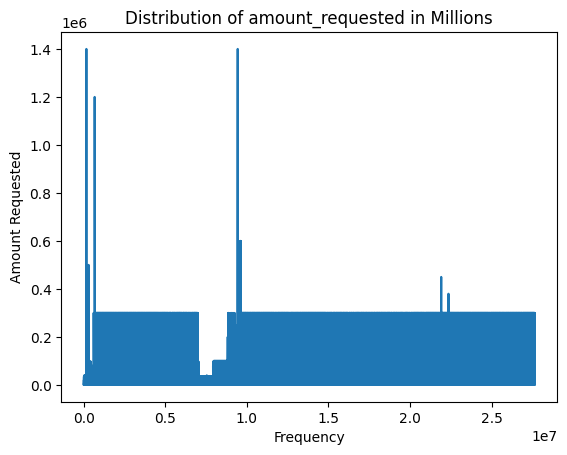

In [101]:
# 1. Plot Max values from amount_requested
plt.plot(data_copy['amount_requested'])
plt.title('Distribution of amount_requested in Millions')
plt.xlabel('Frequency')
plt.ylabel('Amount Requested')


#Calculate percentiles
percentiles = data_copy['amount_requested'].quantile([0.90, 0.95, 0.999])
print(percentiles)

#see the top resquested amount
data_amount_requested = data_copy.sort_values(by='amount_requested', ascending=False)
data_amount_requested

The plots tell us:

* We got extreme values (3 over $1.2 millions) 2 of them been for buying a car. We also got high values arround 600K.
* 95% of the amount_requested in term of distribution is less than 35K

\
On Lending Club, personnal loan are limited to 40K per loan and $50K on total loans (for all the loans for 1 person). So loans that exceed this amount will automatically be rejected.
For the purpose of our analysis, we will get rid of the record with a requested amount > to 50K.


In [102]:
#1. Delete extreme values on amount_requested
data_copy = data_copy[data_copy['amount_requested']<= 50000]

#### 2. Missing values from loan_title

In [103]:
#2. check the missing values fom loan_title
data_copy[data_copy['loan_title'].isna() ]

,amount_requested,application_date,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,policy_code
13863,25000.0,2008-04-06,NaN,643.0,17.33%,681xx,NE,1 year,0.0
31073,15000.0,2009-01-03,NaN,511.0,12.92%,631xx,MO,5 years,0.0
31076,10000.0,2009-01-03,NaN,621.0,2.31%,631xx,MO,5 years,0.0
31976,5000.0,2009-01-12,NaN,626.0,9.06%,631xx,MO,1 year,0.0
31979,2000.0,2009-01-12,NaN,0.0,0%,631xx,MO,3 years,0.0
32491,15000.0,2009-01-17,NaN,NaN,-1%,328xx,FL,2 years,0.0
39831,15000.0,2009-03-25,NaN,616.0,13.94%,481xx,MI,10+ years,0.0
43349,10500.0,2009-04-16,NaN,704.0,7.64%,200xx,DC,10+ years,0.0
43653,1000.0,2009-04-17,NaN,NaN,-1%,303xx,GA,2 years,0.0
55640,14600.0,2009-06-09,NaN,0.0,0%,440xx,OH,< 1 year,0.0


These values seems reasonable but we need to delete them for the purpose of our Topic Modeling

In [104]:
#Delete missing values from loan_title
data_copy = data_copy[data_copy['loan_title'].notna()]

#### 3. debt_to_income_ratio transformation

In [105]:
# 2. Delete '%' from 'debt_to_income_ratio' and convert the column to numeric
data_copy['debt_to_income_ratio'] = data_copy['debt_to_income_ratio'].str[:-1]
data_copy['debt_to_income_ratio'] = pd.to_numeric(data_copy['debt_to_income_ratio'])


The column debt_to_income_ratio is now in the right format. But it contains  negative values and extreme values which is much likely error data entries. We will handle this too.

In [106]:
#1. print the rows with negative values
data_copy[data_copy['debt_to_income_ratio'] < 0]

,amount_requested,application_date,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,policy_code
10521,2000.0,2008-03-07,help credit cards problems,673.0,-1.0,NaN,NaN,< 1 year,0.0
10553,7500.0,2008-03-07,Looking for better rates!,614.0,-1.0,NaN,NaN,< 1 year,0.0
10559,5000.0,2008-03-07,buying car for work,NaN,-1.0,203xx,DC,< 1 year,0.0
10565,25000.0,2008-03-07,Looking to Grow My Business,NaN,-1.0,919xx,CA,2 years,0.0
10570,2000.0,2008-03-07,Medical Fee,NaN,-1.0,906xx,CA,1 year,0.0
...,...,...,...,...,...,...,...,...,...
27648711,8000.0,2016-12-31,other,NaN,-1.0,787xx,TX,5 years,0.0
27648715,40000.0,2016-12-31,major_purchase,NaN,-1.0,148xx,NY,NaN,0.0
27648717,10000.0,2016-12-31,other,NaN,-1.0,531xx,WI,< 1 year,0.0
27648724,9000.0,2016-12-31,debt_consolidation,NaN,-1.0,856xx,AZ,< 1 year,0.0


In [107]:
#1. delete them
data_copy = data_copy[data_copy['debt_to_income_ratio'] >= 0]

In [108]:
#2. check extreme values
data_copy_sorted = data_copy[data_copy['debt_to_income_ratio'] >= 200]
data_copy_sorted.sort_values(by='debt_to_income_ratio', ascending=False)

,amount_requested,application_date,loan_title,risk_score,debt_to_income_ratio,zip_code,state,employment_length,policy_code
434791,1500.0,2012-01-26,other,465.0,50000031.49,921xx,CA,< 1 year,0.0
26431865,40000.0,2016-10-13,debt_consolidation,NaN,7374826.00,797xx,TX,< 1 year,0.0
14353345,9000.0,2016-03-10,debt_consolidation,NaN,7130330.00,655xx,MO,< 1 year,0.0
460442,25000.0,2012-03-12,credit_card,629.0,4408800.00,294xx,SC,< 1 year,0.0
13762336,11000.0,2016-01-19,debt_consolidation,NaN,3974439.00,812xx,CO,< 1 year,0.0
...,...,...,...,...,...,...,...,...,...
12968438,8000.0,2017-09-04,Debt consolidation,672.0,200.00,920xx,CA,< 1 year,0.0
11486097,1000.0,2018-03-28,Car financing,NaN,200.00,441xx,OH,< 1 year,0.0
11486657,1200.0,2018-03-28,Moving and relocation,NaN,200.00,291xx,SC,< 1 year,0.0
23707719,1000.0,2015-10-04,other,NaN,200.00,936xx,CA,< 1 year,0.0


Text(0.5, 1.0, 'Distribution of debt_to_income_ratio >=200%')

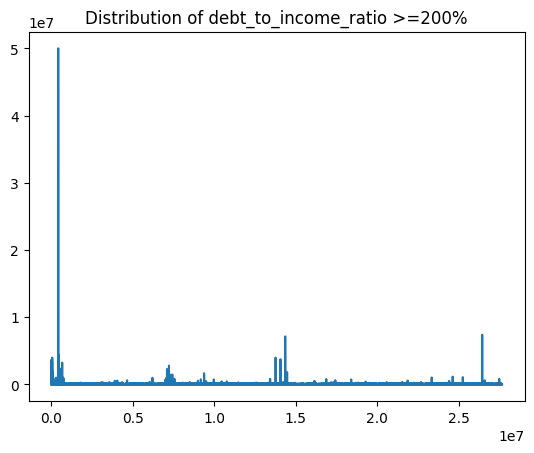

In [199]:
# 1. Plot Max values from amount_requested
plt.plot(data_copy_sorted['debt_to_income_ratio'])
plt.title('Distribution of debt_to_income_ratio >=200%')

A debt-to-income ratio (DTI) over 200% is technically possible but extremely rare.

A DTI above 100% means the person is already spending more on debt than they earn. This isn’t just risky—it makes it impossible for them to handle more debt responsibly.

LendingClub and other lenders follow rules that ensure people can repay loans, as required by laws like the Dodd-Frank Act in the U.S. These rules make sure borrowers can handle loan payments without serious financial problems.

Lending platforms use algorithms to check for financial risks. A DTI over 100% would lead to an automatic rejection.

\

For the purpose of the Topic Modeling and clustering, we will get rid of DTI superior to 200% which can skwed our dataset and the clusters


In [109]:
#get rid of debt_to_income_ratio superior of 200
data_copy = data_copy[data_copy['debt_to_income_ratio'] <=200.0]

#### 4. Convert employment_length

In [110]:
#check the unique values from employment_length
data_copy['employment_length'].unique()

array(['4 years', '< 1 year', '1 year', '3 years', '2 years', '10+ years',
       '9 years', '5 years', '7 years', '6 years', '8 years', nan],
      dtype=object)

In [111]:
#Proceed the mapping of those values
employment_length_mapping = {
    '< 1 year' : 0.5,
    '1 year' : 1,
    '2 years' : 2,
    '3 years' : 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

#map the values. THis will also convert the coluns to numeric
data_copy['employment_length'] = data_copy['employment_length'].map(employment_length_mapping)


#### 5. Create column application_year and application_month

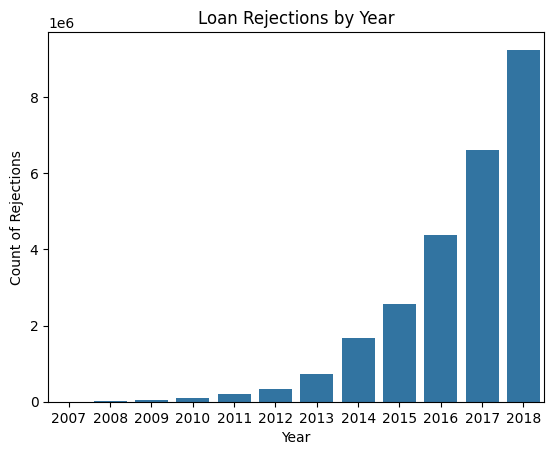

In [112]:
#1. Create a column 'application_year'
data_copy['application_year'] = data_copy['application_date'].str[:4]
data_copy['application_year'] = pd.to_numeric(data_copy['application_year'])

# Plot the count of rejections per year
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=data_copy, x='application_year')
plt.title('Loan Rejections by Year')
plt.xlabel('Year')
plt.ylabel('Count of Rejections')
plt.show()

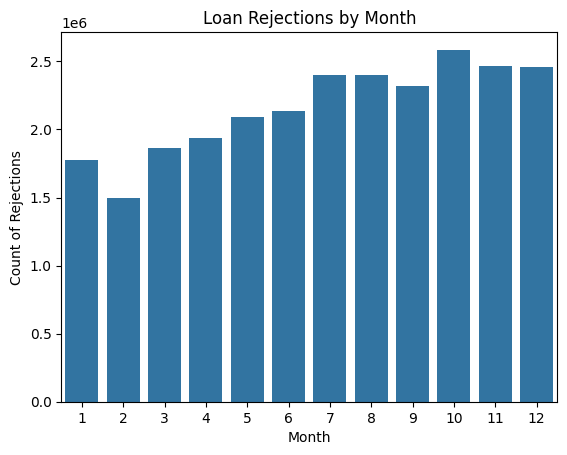

In [200]:
# Extract month from application_date
data_copy['application_month'] = pd.to_datetime(data_copy['application_date']).dt.month

# Plot the count of rejections per month
sns.countplot(data=data_copy, x='application_month')
plt.title('Loan Rejections by Month')
plt.xlabel('Month')
plt.ylabel('Count of Rejections')
plt.show()


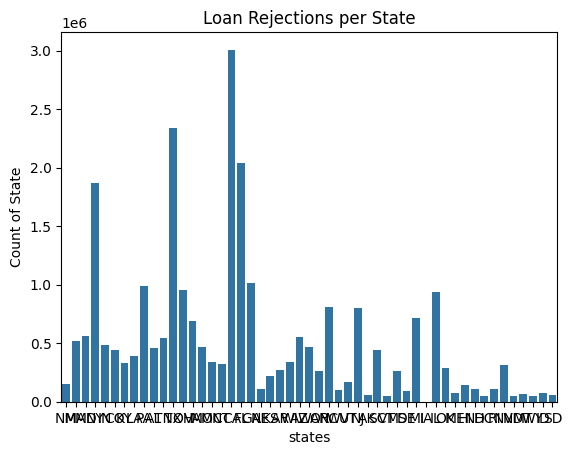

In [114]:
# Plot the count of rejections per state
sns.countplot(data=data_copy, x='state')
plt.title('Loan Rejections per State')
plt.xlabel('states')
plt.ylabel('Count of State')
plt.show()


Loan rejections seem to increase from February to November, but the difference between months isn’t very big.

It’s possible that more people apply for loans during certain months, which could explain why there are more rejections. The rise in rejections might be due to more loan applications rather than stricter rules. It wouldn’t really make sense to say the month itself causes loans to get rejected.



#### 6.  summary

In [115]:
# run summary
print('Data Type:\n', data_copy.info())
print('Sum of Null values: \n', data_copy.isna().sum())
print('Description of numeric values:\n', data_copy.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 25936014 entries, 0 to 27648740
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   amount_requested      float64
 1   application_date      object 
 2   loan_title            object 
 3   risk_score            float64
 4   debt_to_income_ratio  float64
 5   zip_code              object 
 6   state                 object 
 7   employment_length     float64
 8   policy_code           float64
 9   application_year      int64  
 10  application_month     int32  
dtypes: float64(5), int32(1), int64(1), object(4)
memory usage: 2.2+ GB
Data Type:
 None
Sum of Null values: 
 amount_requested               0
application_date               0
loan_title                     0
risk_score              16966532
debt_to_income_ratio           0
zip_code                       1
state                          0
employment_length         906100
policy_code                  916
application_year           

## Preprocessing



1. Plot missing values per year and features
2. Ignore irrelevant features
3. Correlation matrix
4. Normalise 'loan_title' : clean the title and Manually Group some title together
5. Impute missing values on employment_length and policy_code
6. Scale the features
7. Encode state using One-hot
8. Transform loan_title using TF-IDF technique

#### Plot Missing values

<ipython-input-116-35c88c131580>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_copy_missing_values_per_year = data_copy.groupby('application_year').apply(lambda x: x.isna().sum())


                  amount_requested  application_date  loan_title  risk_score  \
application_year                                                               
2007                             0                 0           0         104   
2008                             0                 0           0         395   
2009                             0                 0           0          48   
2010                             0                 0           0        4618   
2011                             0                 0           0          79   
2012                             0                 0           0         158   
2013                             0                 0           0       11869   
2014                             0                 0           0       27956   
2015                             0                 0           0     2078536   
2016                             0                 0           0     3384769   
2017                             0      

<Figure size 1000x600 with 0 Axes>

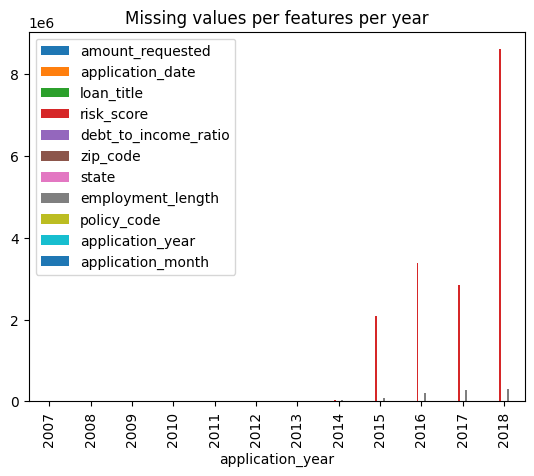

In [116]:
#Plot Missing values per year
data_copy_missing_values_per_year = data_copy.groupby('application_year').apply(lambda x: x.isna().sum())
plt.figure(figsize=(10,6))
data_copy_missing_values_per_year.plot(kind='bar')
plt.title('Missing values per features per year')

#table of missing value per year
print(data_copy_missing_values_per_year)

application_year
2007       5214
2008      23125
2009      49504
2010     107280
2011     207941
2012     329444
2013     738759
2014    1666884
2015    2575959
2016    4383109
2017    6609017
2018    9239778
Name: amount_requested, dtype: int64


Text(0.5, 1.0, 'Count record per year')

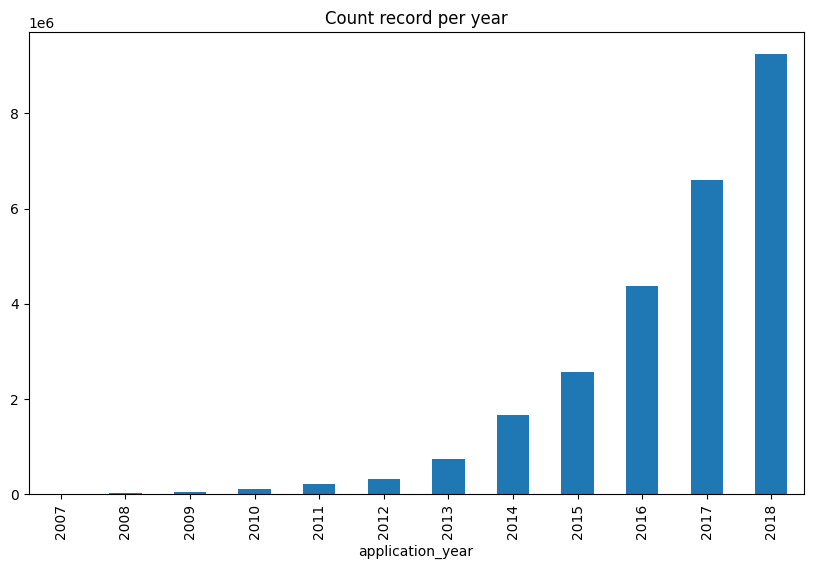

In [117]:
# record per year
data_copy_record_per_year = data_copy.groupby('application_year').agg('count')
data_copy_record_per_year = data_copy_record_per_year['amount_requested'].T

print(data_copy_record_per_year)

#plot
plt.figure(figsize=(10,6))
data_copy_record_per_year.plot(kind='bar')
plt.title('Count record per year')


In [118]:
#missing value data
data_copy_missing_values = data_copy.isna().sum()
data_copy_missing_values = data_copy_missing_values.T #transpose the missing values dataset

#df Missing values in number
print(data_copy_missing_values)

amount_requested               0
application_date               0
loan_title                     0
risk_score              16966532
debt_to_income_ratio           0
zip_code                       1
state                          0
employment_length         906100
policy_code                  916
application_year               0
application_month              0
dtype: int64


The plots tells us that:
* The data is heavily concentrated from 2015 to 2018 (with 2018 having the largest number of records). Ignoring these years would result in a significant reduction in your dataset size, which might affect the richness of the analysis.
* A lot of Missing values on risk_score which are mostly between 2015 and 2018 with most of them been on 2018. They represent 68% of the rows on the dataset. This also implies that most of the record are from 2018 since (8millions missing values)
* Few missing values on zip_code (1), employment_length, policy_code


Next steps:
1. Ignore 'risk_score' value for the analysis since we got 68% missing values
2. Check the correlation between the numeric features
3. Impute employment_length and policy_code missing values


#### Ignore irrelevant conlumns

Keeping only:


amount_requested
debt_to_income_ratio
employment_length
policy_code
application_year
loan_title_grouped (loan_title)



In [119]:
# Create anothe Dataset without risk_score
data_cleaned = data_copy.copy()

to_drop = ['risk_score', 'application_date', 'application_month', 'zip_code']
#drop the column
data_cleaned = data_cleaned.drop(to_drop, axis=1)

#### Correlation Matrix

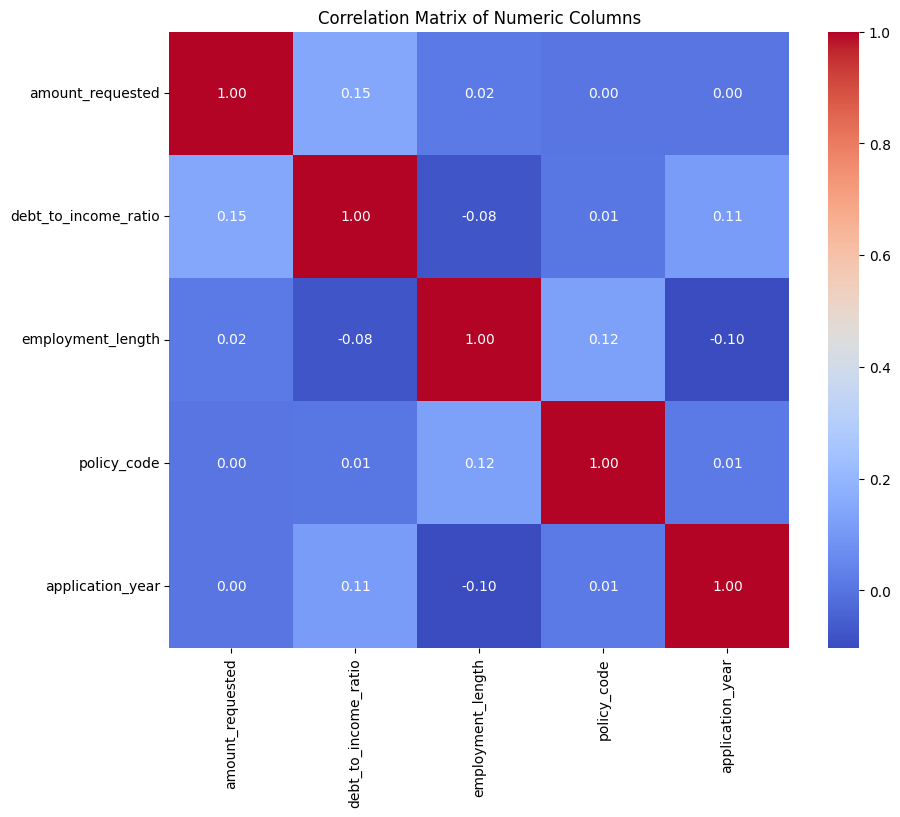

In [120]:
# Check correlation between numerical features
#Filter on numeric columns
numeric_data = data_cleaned.select_dtypes(include =['float64', 'int64'])

correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Columns')
plt.show()


#### Impute employment_length and policy_code

Since there is no meaningful correlation between features, I will proceeding with median imputation rather than more advance techniques like KNN

In [121]:
#calcul median
median_employment_length = data_cleaned['employment_length'].median()
median_employment_length = data_cleaned['policy_code'].median()

#fill missing values with the median
data_cleaned.fillna({'employment_length' :median_employment_length}, inplace = True)
data_cleaned.fillna({'policy_code' :median_employment_length}, inplace = True)

#### Normalised 'loan_title'

In [122]:
# Normalize loan titles by converting to lowercase and removing underscores
data_cleaned['loan_title'] = data_cleaned['loan_title'].str.lower()

# Remove extra spaces and special characters
data_cleaned['loan_title'] = data_cleaned['loan_title'].apply(lambda x: re.sub(r'\s+', ' ', str(x).strip()))
data_cleaned['loan_title'] = data_cleaned['loan_title'].apply(lambda x: re.sub(r'[^a-zA-Z0-9 ]', '', x))


In [123]:
# Find the most frequent loan titles
loan_title_counts = data_cleaned['loan_title'].value_counts().head(30)
print(loan_title_counts)

loan_title
debt consolidation         6296497
debtconsolidation          5461852
other                      4443147
credit card refinancing    2248845
creditcard                 1259856
car financing               751178
homeimprovement             655212
home buying                 485627
major purchase              474369
car                         468824
home improvement            457402
majorpurchase               425006
medical expenses            381935
moving                      338413
medical                     324225
moving and relocation       311483
vacation                    282705
smallbusiness               280819
business                    208786
house                       165065
renewableenergy              27752
green loan                   23436
wedding                      17701
                             12657
consolidation                 3183
personal loan                 3107
personal                      2459
debt consolidation loan       2106
education


- "Debt consolidation" shows up a lot with over 11 million entries. Similar terms like "consolidation", "debt consolidation loan", and "consolidate" can be grouped together under "Debt Consolidation".
  
- Terms like "credit card refinancing", "credit card", and "credit card consolidation" can all be grouped under "Credit Card".

- The category "Other" is quite large, with over 4.4 million entries. We could explore it further or leave it as a catch-all for various loan purposes.

- Terms like "personal loan", "personal", and "loan" can be grouped into a broader "Personal Loan" category.

- "Medical expenses" and "medical" can be grouped into "Medical".

- "Moving" and "moving and relocation" can be grouped under "Moving and Relocation".

We also found 12K rows with empty or strange characters in the loan titles. For the purpose of topic modeling and clustering, we will remove these rows.

**Conclusion:**  
12K loans might have been rejected because they had unclear or nonsense loan titles.

In [124]:
# Define a function to detect titles with mostly special characters
def is_invalid_title(title):
    # Remove any title that contains fewer than 3 alphanumeric characters or contains mostly non-alphabetic characters or empty title after strip
    if title.strip() == '':
        return True
    return bool(re.match(r'^[^a-zA-Z]{2,}$', title.strip()))

# Apply the filter to remove invalid titles
data_cleaned = data_cleaned[~data_cleaned['loan_title'].apply(is_invalid_title)]

In [125]:
# Rerun the most frequent loan titles
loan_title_counts = data_cleaned['loan_title'].value_counts().head(30)
print(loan_title_counts)

loan_title
debt consolidation           6296497
debtconsolidation            5461852
other                        4443147
credit card refinancing      2248845
creditcard                   1259856
car financing                 751178
homeimprovement               655212
home buying                   485627
major purchase                474369
car                           468824
home improvement              457402
majorpurchase                 425006
medical expenses              381935
moving                        338413
medical                       324225
moving and relocation         311483
vacation                      282705
smallbusiness                 280819
business                      208786
house                         165065
renewableenergy                27752
green loan                     23436
wedding                        17701
consolidation                   3183
personal loan                   3107
personal                        2459
debt consolidation loan    

In [126]:
loan_title_mapping = {
    'debt consolidation': 'Debt Consolidation',
    'consolidation': 'Debt Consolidation',
    'debt consolidation loan': 'Debt Consolidation',
    'debtconsolidation': 'Debt Consolidation',
    'consolidate': 'Debt Consolidation',
    'credit card refinancing': 'Credit Card',
    'credit_card' : 'Credit Card',
    'credit_card_consolidation' : 'Credit Card',
    'credit card': 'Credit Card',
    'creditcard': 'Credit Card',
    'credit card consolidation': 'Credit Card',
    'debt_consolidation': 'Debt Consolidation',
    'home improvement': 'Home Improvement',
    'major purchase': 'Major Purchase',
    'car financing': 'Car Financing',
    'car': 'Car Financing',
    'home buying': 'Home Buying',
    'medical expenses': 'Medical',
    'medical': 'Medical',
    'moving': 'Moving and Relocation',
    'moving and relocation': 'Moving and Relocation',
    'vacation': 'Vacation',
    'small business': 'Small Business',
    'smallbusiness': 'Small Business',
    'business': 'Small Business',
    'small_business': 'Small Business',
    'house': 'Home Buying',
    'home loan': 'Home Buying',
    'renewable energy': 'Green Loan',
    'green loan': 'Green Loan',
    'wedding': 'Wedding',
    'personal loan': 'Personal Loan',
    'personal': 'Personal Loan',
    'loan': 'Personal Loan',
    'student loan': 'Student Loan',
    'educational': 'Educational Loan',
    'other': 'Other',
    'credit card refinance': 'Credit Card',
    'credit card payoff': 'Credit Card',
    'credit card loan': 'Credit Card',
    'credit cards': 'Credit Card',
    'consolidation loan': 'Debt Consolidation',
    'debt': 'Debt Consolidation',
    'consolidate debt': 'Debt Consolidation',
    'payoff': 'Debt Consolidation',
    'small business loan': 'Small Business',
    'business loan': 'Small Business',
    'car loan': 'Car Financing',
    'my loan': 'Personal Loan',
    'freedom': 'Freedom',
    'debt free': 'Debt Consolidation',
    'home improvement loan': 'Home Improvement',
    'home': 'Home Improvement',
    'school loan': 'Educational Loan',
    'school': 'Educational Loan',
    'education': 'Educational Loan',
    'pay off credit cards': 'Credit Card',
    'pay off': 'Credit Card',
    'credit card debt': 'Credit Card',
    'bills': 'Personal Loan',
    'debt loan': 'Debt Consolidation',
    'refinance': 'Debt Consolidation',
    'homeimprovement' : 'Home Improvement',
    'majorpurchase': 'Major Purchase',
    'renewableenergy': 'Green Loan',
    'credit card pay off': 'Credit Card',
    'credit consolidation': 'Credit Card',
    'credit card refi': 'Credit Card',
    'debt payoff': 'Debt Consolidation',
    'get out of debt': 'Debt Consolidation',
    'bill consolidation': 'Debt Consolidation',
    'auto loan': 'Car Financing',
    'motorcycle': 'Car Financing',
    'motorcycle loan': 'Car Financing',
    'help': 'Other',
    'wedding loan': 'Wedding',
    'wedding expenses': 'Wedding',
    'education loan': 'Educational Loan',
    'college': 'Educational Loan',
    'pay off debt': 'Debt Consolidation',
    'debt relief': 'Debt Consolidation',
    'debt consolidate': 'Debt Consolidation',
    'loan consolidation': 'Debt Consolidation',
    'home improvements': 'Home Improvement',
    'medical loan': 'Medical',
    'lending club': 'Other',
    'credit': 'Credit Card',
    'cc consolidation': 'Credit Card',
    'cc payoff': 'Credit Card',
    'credit card refinance loan': 'Credit Card',
    'credit card debt consolidation': 'Credit Card',
    'consolidate credit cards': 'Credit Card',
    'debt consol': 'Debt Consolidation',
    'debt consolodation': 'Debt Consolidation',
    'debit consolidation': 'Debt Consolidation',
    'pool': 'Pool Loan',
    'pool loan': 'Pool Loan',
    'lending club loan': 'Other',
    'loan 1': 'Other',
    'loan1': 'Other',
    'pay off bills': 'Debt Consolidation',
    'pay bills': 'Debt Consolidation',
    'new start': 'New Start',
    'fresh start': 'New Start',
    'relief': 'Debt Consolidation',
    'moving loan': 'Moving and Relocation',
    'moving expenses': 'Moving and Relocation',
    'college loan': 'Educational Loan',
    'business expansion': 'Small Business',
    'investment': 'Small Business',
    'working capital': 'Small Business',

}

# Apply the mapping dictionary using .map()
data_cleaned['loan_title_grouped'] = data_cleaned['loan_title'].apply(lambda x: loan_title_mapping.get(x, x))

In [127]:
# Check the grouped loan titles and their frequencies
print(data_cleaned['loan_title_grouped'].value_counts().head(20))

loan_title_grouped
Debt Consolidation       11771139
Other                     4444090
Credit Card               3516496
Car Financing             1221367
Home Improvement          1113817
Major Purchase             899375
Medical                    706348
Home Buying                650981
Moving and Relocation      650160
Small Business             492037
Vacation                   282705
Green Loan                  51199
Wedding                     18188
Personal Loan                7818
Educational Loan             3954
Student Loan                 1258
Freedom                       548
Pool Loan                     296
New Start                     279
major purchase loan           171
Name: count, dtype: int64


In [128]:
len(data_cleaned['loan_title_grouped'].unique())

59042

Good to go !

#### Scale the features : amount_requested, debt_to_income_ratio and employment_length

**Why these features?**

**amount_requested (US Dollars):**  
This is the amount of money people are asking for. It's ranging from 25 to $50,000. Since the amounts are large compared to other features, we need to scale it so it doesn’t overpower the clustering process.

**debt_to_income_ratio (percentage):**  
This is the percentage of a person’s income that goes toward debt, ranging from 0% to 200%. Like loan amounts, it has a different range, and scaling will make sure it’s balanced with other features in the clustering.

**employment_length (Years):**  
This shows how many years the borrower has been working, from 0.5 to 10 years. Although the range is small, we still need to scale it so that it’s not overshadowed by larger features like loan amounts.

In [129]:
#Scale the numerical columns from the dataset using sklearn standard scaler

# Apply StandardScaler to numerical features
scaler = StandardScaler()
data_cleaned[['amount_requested', 'debt_to_income_ratio', 'employment_length']] = scaler.fit_transform(
          data_cleaned[['amount_requested', 'debt_to_income_ratio', 'employment_length']])

In [130]:
# Drop the original 'loan_title' column as it's no longer needed
data_cleaned.drop('loan_title', axis=1, inplace=True)

In [131]:
data_cleaned.columns

Index(['amount_requested', 'debt_to_income_ratio', 'state',
       'employment_length', 'policy_code', 'application_year',
       'loan_title_grouped'],
      dtype='object')

#### Encode 'state' using One-hot encoder




In [132]:
# Initialize the One-Hot Encoder
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform the 'state' column
state_encoded = onehot_encoder.fit_transform(data_cleaned[['state']])
state_encoded_df = pd.DataFrame(state_encoded, columns=onehot_encoder.get_feature_names_out(['state']))

# Reset the index for the new DataFrame
state_encoded_df.index = data_cleaned.index

# Drop the original 'state' column from the dataset and concatenate the encoded states
data_cleaned = pd.concat([data_cleaned.drop(columns=['state']), state_encoded_df], axis=1)

# Check NaN values. We never know...
print(data_cleaned.isna().sum())

amount_requested        0
debt_to_income_ratio    0
employment_length       0
policy_code             0
application_year        0
loan_title_grouped      0
state_AL                0
state_AR                0
state_AZ                0
state_CA                0
state_CO                0
state_CT                0
state_DC                0
state_DE                0
state_FL                0
state_GA                0
state_HI                0
state_IA                0
state_ID                0
state_IL                0
state_IN                0
state_KS                0
state_KY                0
state_LA                0
state_MA                0
state_MD                0
state_ME                0
state_MI                0
state_MN                0
state_MO                0
state_MS                0
state_MT                0
state_NC                0
state_ND                0
state_NE                0
state_NH                0
state_NJ                0
state_NM                0
state_NV    

#### Apply TF-IDF (Term Frequency-Inverse Document Frequency) on loan_title_grouped

TF-IDF is a method used in text analysis to turn text into numeric values.

Since algorithms like NMF need numeric to work we use TF-IDF to convert loan titles (which are text) into numeric. TF-IDF helps figure out how important a word is to a specific loan title compared to all other loan titles. Common words like "loan" will for sure get less weight while more specific words like "home improvement" will get higher weights.

In [133]:
#Vectorize the loan titles using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_cleaned['loan_title_grouped'])

#### Final summary

In [134]:
#Final summary
print('length of the dataset: \n', len(data_cleaned))
print('Description of numeric values: \n', data_cleaned.describe())
print('Sum of Null values: \n', data_cleaned.isna().sum())
print('Data types:\n ', data_cleaned.info())

length of the dataset: 
 25923180
Description of numeric values: 
        amount_requested  debt_to_income_ratio  employment_length  \
count      2.592318e+07          2.592318e+07       2.592318e+07   
mean      -5.915858e-17          7.678095e-16       7.474694e-17   
std        1.000000e+00          1.000000e+00       1.000000e+00   
min       -1.165423e+00         -1.019535e+00      -6.126385e-01   
25%       -7.357855e-01         -6.718243e-01      -3.349317e-01   
50%       -2.286722e-01         -2.651862e-01      -3.349317e-01   
75%        7.104264e-01          3.109148e-01      -3.349317e-01   
max        3.527723e+00          6.300682e+00       4.941498e+00   

        policy_code  application_year      state_AL      state_AR  \
count  2.592318e+07      2.592318e+07  2.592318e+07  2.592318e+07   
mean   5.793271e-03      2.016520e+03  1.779859e-02  1.056714e-02   
std    1.074848e-01      1.649217e+00  1.322188e-01  1.022520e-01   
min    0.000000e+00      2.007000e+03  0.000

## UML Techniques : Topic Modeling and Clustering


NMF is a matrix factorization technique that decomposes the document-term matrix into two lower-dimensional matrices, which can be interpreted as topics


**Advantages**:
- NMF is often better than LDA for short texts because it doesn’t use a probabilistic model.
- NMF is usually quicker than LDA, especially when dealing with short texts or large datasets.
-  Simplier resultto interpret, similar to LDA.

In [137]:
data_test = data_cleaned.copy()

In [140]:
# Apply NMF for topic modeling
n_topics = 12
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_model.fit(tfidf)

# Function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top words for each topic
nb_top_words = 12
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(nmf_model, tfidf_feature_names, nb_top_words)

Topic 0:
consolidation debt pay loan consolidate free help consolidating paying payoff personal cc
Topic 1:
card credit pay cards payoff consolidate refinance loan high paying payment help
Topic 2:
improvement home loan payment new project repair improvment repairs purchase consolidate help
Topic 3:
financing car need new repair used repairs pay loan purchase payment buy
Topic 4:
major purchase loan car home motorcycle equipment vehicle inventory auto business new
Topic 5:
medical bills expenses pay expense help school loan need consolidate payoff cards
Topic 6:
relocation moving expenses loan forward expense job new help school need home
Topic 7:
small business start loan startup new expansion capital investment starting expanding expand
Topic 8:
buying home payment new repair improvment repairs purchase loan help car need
Topic 9:
vacation loan family dream summer money time pay needed need hawaii home
Topic 10:
loan green personal educational student pay pool need payoff school refi

In [141]:
# Transform the original data using the NMF model
nmf_features = nmf_model.transform(tfidf)

# Convert the topic features into a DataFrame for easier handling
nmf_df = pd.DataFrame(nmf_features, columns=[f'Topic_{i}' for i in range(n_topics)])

# Reset indices of both data_test and nmf_df to ensure they align properly
data_test.reset_index(drop=True, inplace=True)
nmf_df.reset_index(drop=True, inplace=True)

# Combine the original numeric features with the new NMF topic features
data_test = pd.concat([data_test.drop(columns=['loan_title_grouped']), nmf_df], axis=1)

I tried 10, 12, and 15 topics:

- **10 topics**: The topics are clear but combine some categories like personal and educational loans, losing specific details.
- **15 topics**: This adds more detail, splitting into categories like student loans and credit card refinancing, but it creates too much overlap.
- **12 topics**: This gives a good balance, with clear categories like medical, vacation, and small business loans, without too much confusion.

**Final Choice**:  
We chose 12 topics because it offers the best mix of detail and clarity.
\
**Next steps**
1. Apply K-means++ on the dataset


### **K-Means ++**

K-Means is a method that divides the dataset into K clusters, where each point is assigned to the cluster with the closest centroid.

K-Means++ starts by picking the first center randomly, then chooses the next ones based on their distance from the already chosen centers, ensuring that each centroid is well spread out.

The algorithm gives K groups, each with a center, and shows which data points belong to which group.

K-Means is computationally efficient with a complexity of O(N * K * T), where N is the number of data points, K is the number of clusters, and T is the number of iterations.
This is important since our dataset contains millions of data points.

#### Elbow Method

**Elbow Method**:
The elbow method is used to find the optimal number of clusters by looking at how the inertia (sum of squared distances of samples to their closest cluster center) changes as we increase the number of clusters.
It is especially useful for large datasets because it helps in determining the point where adding more clusters stops providing significant improvement in
clustering quality.

\
**Silhouette Score**:
This score assesses how well data points fit into
their assigned clusters compared to others. The score ranges from −1 to
+1, where a high value indicates a good clustering. A clustering with an
average silhouette width of over 0.7 is "strong", a value over 0.5
"reasonable" and over 0.25 "weak". On real world data, we usually
expect a score around 0.5.

Since our dataset is really big, we will calculate the silhouette scores only on a random sample of 100K rows of the dataset.

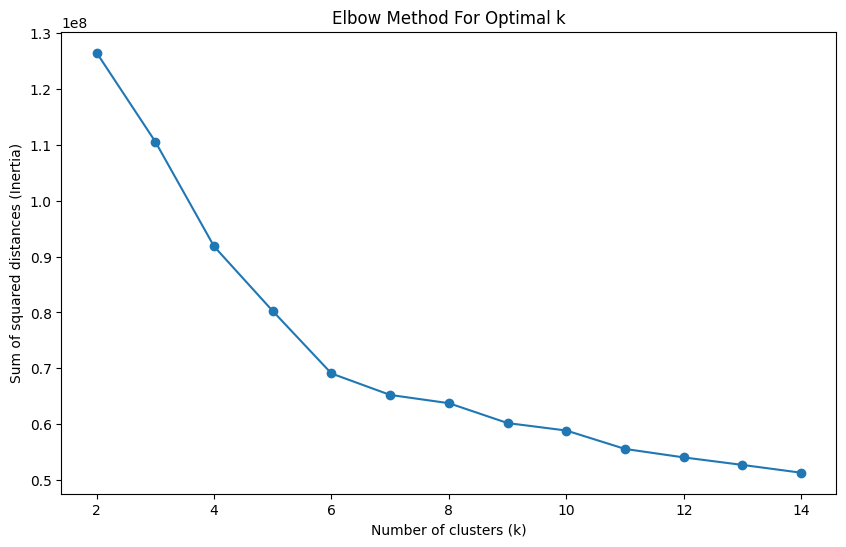

In [146]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract the features from data_test for clustering
X = data_test.values

# Define the range for the number of clusters
k_range = range(2, 15)

# List to store the sum of squared distances for each number of clusters (inertia)
sse = []

# Perform KMeans for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(X)
    sse.append(kmeans.inertia_)  # Inertia: sum of squared distances to nearest cluster center


plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

Elbow at 6 clusters. We will try  6, 7, 9 and 12 cluster and display the silhouette score

#### K-Means ++

In [176]:
#create a copy of the dataset for the clustering step
clustering_result = data_test.copy()
# Define the different number of clusters to use
n_clusters_list = [6, 7, 9, 12]

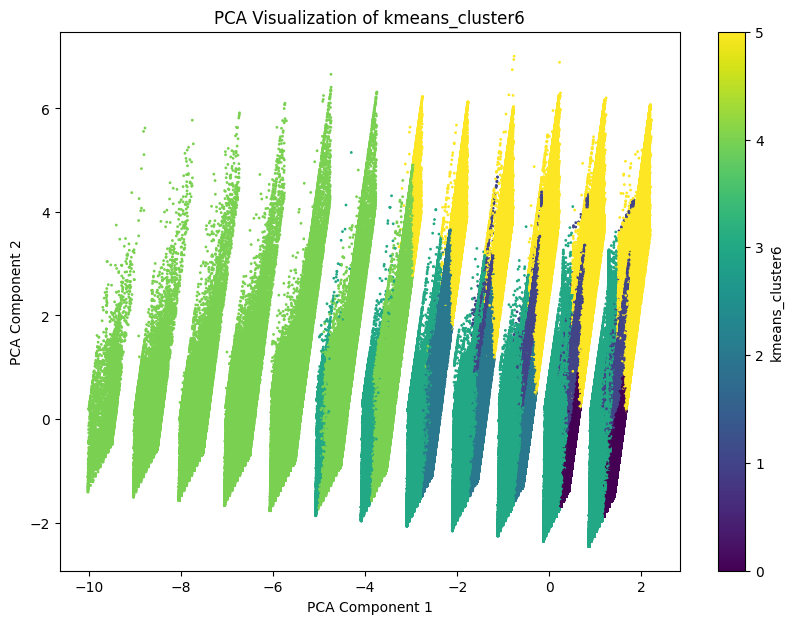

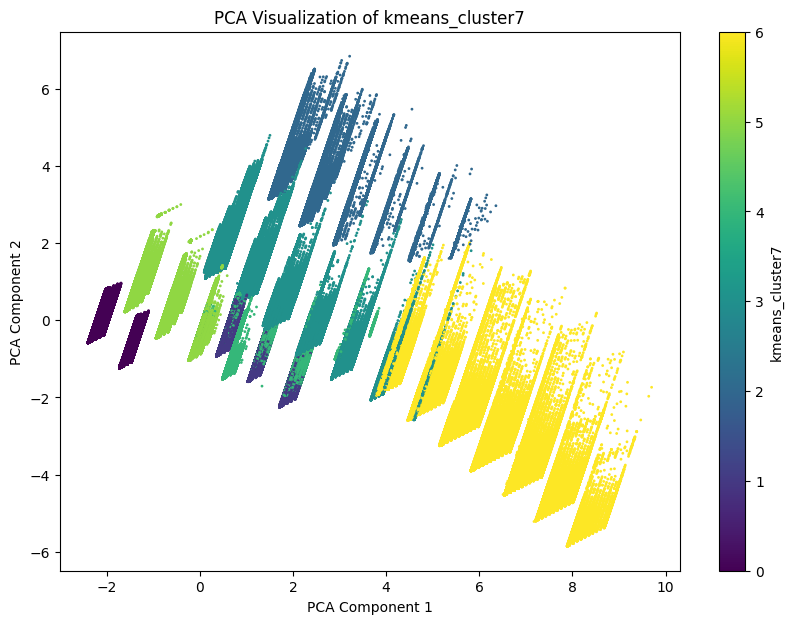

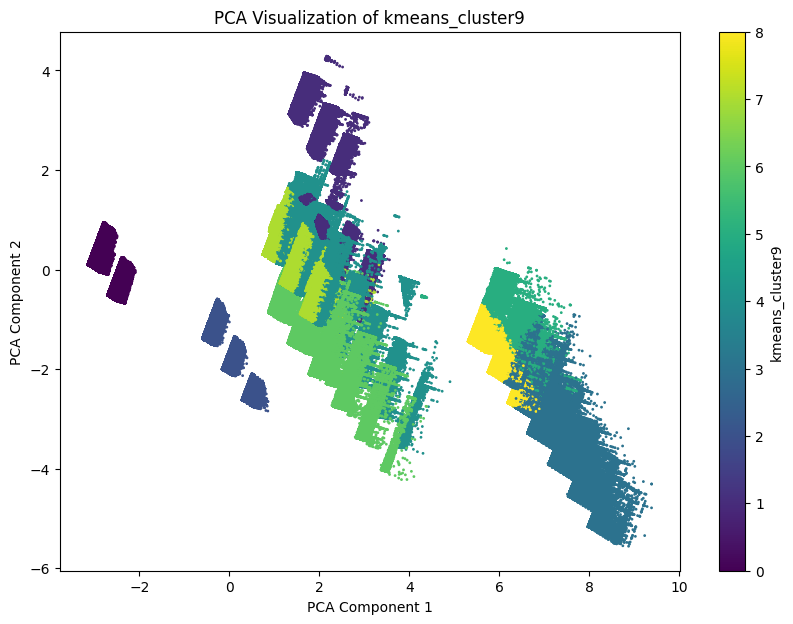

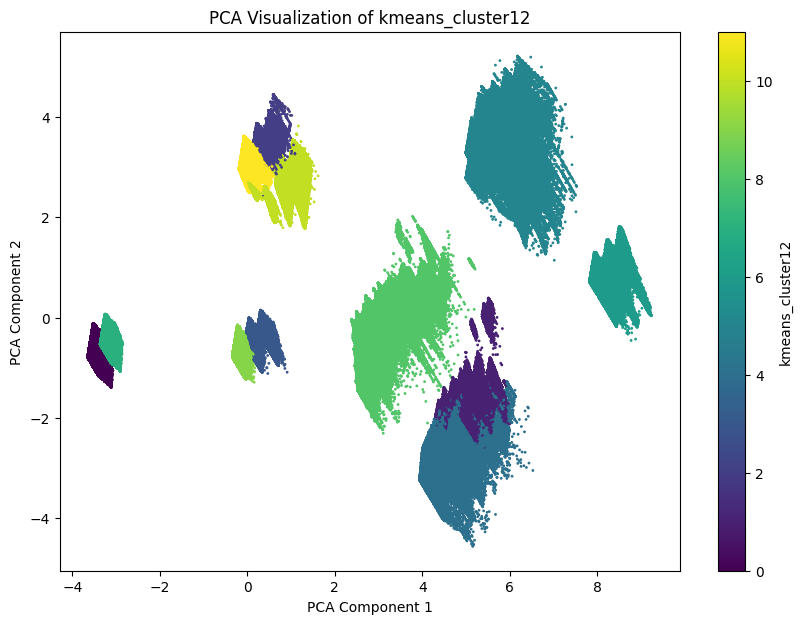

In [177]:

# Initialize an empty dictionary to store PCA results and labels
pca_results = {}

# Perform clustering and PCA visualization for each number of clusters
for n_clusters in n_clusters_list:
    # Initialize KMeans++ with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)

    # Fit the KMeans model on the dataset (excluding previous cluster columns)
    kmeans.fit(clustering_result)

    # Add the cluster labels to the dataset
    clustering_result[f'kmeans_cluster{n_clusters}'] = kmeans.labels_

    # PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(clustering_result.drop(columns=[f'kmeans_cluster{n_clusters}']))
    pca_results[n_clusters] = pca_result

    # Plot PCA results
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clustering_result[f'kmeans_cluster{n_clusters}'], cmap='viridis', s=1)
    plt.title(f"PCA Visualization of kmeans_cluster{n_clusters}")
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label=f'kmeans_cluster{n_clusters}')
    plt.show()


In [160]:
# Randomly sample 100,000 rows for silhouette score calculation
data_sampled = data_test.sample(n=100000, random_state=42)

# List of cluster columns to evaluate for silhouette score
kmeans_result = ['kmeans_cluster6', 'kmeans_cluster7', 'kmeans_cluster9', 'kmeans_cluster12']

# Calculate the silhouette score for each cluster configuration
for cluster in kmeans_result:
    # Prepare the feature set X by excluding the current cluster column
    X = data_sampled.drop(columns=kmeans_result)
    labels = data_sampled[cluster]

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(X, labels)

    print(f"Silhouette Score for {cluster}: {silhouette_avg}")


Silhouette Score for the reduced sample: 0.2592908669522382
Silhouette Score for the reduced sample: 0.26028685853062633
Silhouette Score for the reduced sample: 0.10062061262652257
Silhouette Score for the reduced sample: 0.10062061262652257
Silhouette Score for the reduced sample: 0.1326688484724587


## Visualisation

### Final cluster Model : 6

6 clusters seems like the best option, as it provides a balance between decent cluster separation (higher silhouette score) and lower complexity.
9 and 12 clusters introduce more noise and reduce the clarity of the clusters.

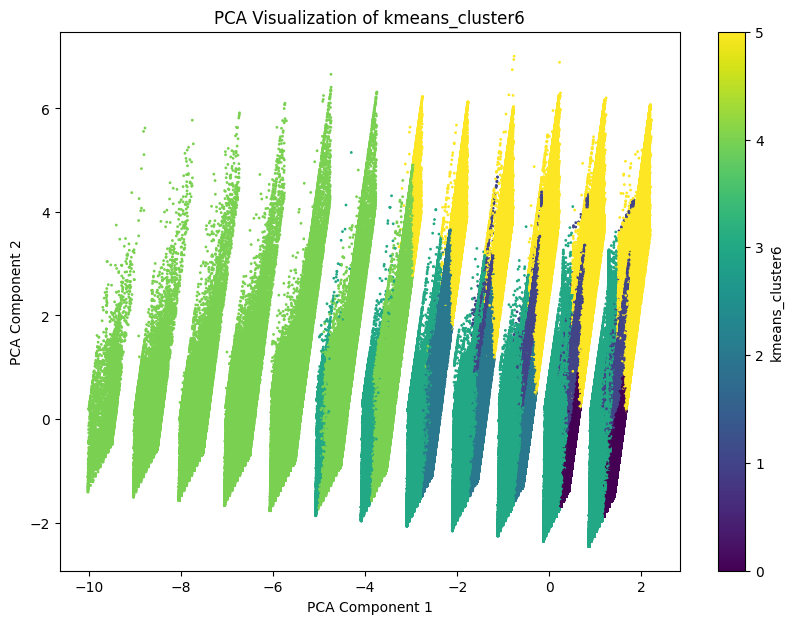

In [180]:
# Perform KMeans clustering with 6 clusters
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)

# Fit the model on the dataset and create labels
kmeans.fit(data_test)
data_test['kmeans_cluster6'] = kmeans.labels_

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_test.drop(columns=['kmeans_cluster6']))

# Plot PCA results
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=data_test['kmeans_cluster6'], cmap='viridis', s=1)
plt.title("PCA Visualization of kmeans_cluster6")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='kmeans_cluster6')
plt.show()


In [182]:
# Re-display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top words for each topic
nb_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
display_topics(nmf_model, tfidf_feature_names, nb_top_words)


Topic 0:
consolidation debt pay loan consolidate free help consolidating paying payoff
Topic 1:
card credit pay cards payoff consolidate refinance loan high paying
Topic 2:
improvement home loan payment new project repair improvment repairs purchase
Topic 3:
financing car need new repair used repairs pay loan purchase
Topic 4:
major purchase loan car home motorcycle equipment vehicle inventory auto
Topic 5:
medical bills expenses pay expense help school loan need consolidate
Topic 6:
relocation moving expenses loan forward expense job new help school
Topic 7:
small business start loan startup new expansion capital investment starting
Topic 8:
buying home payment new repair improvment repairs purchase loan help
Topic 9:
vacation loan family dream summer money time pay needed need
Topic 10:
loan green personal educational student pay pool need payoff school
Topic 11:
wedding expenses expense dream help daughters loan fund day pay


In [186]:
# Label the topics for better interpretation
topic_labels = {
    0: "Debt Consolidation",
    1: "Credit Card Payments",
    2: "Home Improvement",
    3: "Car Financing",
    4: "Major Purchases",
    5: "Medical Expenses",
    6: "Relocation Expenses",
    7: "Small Business Loans",
    8: "Home Buying",
    9: "Vacation and Family Expenses",
    10: "Student and Personal Loans",
    11: "Wedding Expenses"
}

# Display the top words for each topic with the labels
def display_labeled_topics(model, feature_names, no_top_words, topic_labels):
    for topic_idx, topic in enumerate(model.components_):
        label = topic_labels[topic_idx]
        print(f"Topic {topic_idx} - {label}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Re-display the top words with labeled topics
display_labeled_topics(nmf_model, tfidf_feature_names, nb_top_words, topic_labels)


Topic 0 - Debt Consolidation:
consolidation debt pay loan consolidate free help consolidating paying payoff
Topic 1 - Credit Card Payments:
card credit pay cards payoff consolidate refinance loan high paying
Topic 2 - Home Improvement:
improvement home loan payment new project repair improvment repairs purchase
Topic 3 - Car Financing:
financing car need new repair used repairs pay loan purchase
Topic 4 - Major Purchases:
major purchase loan car home motorcycle equipment vehicle inventory auto
Topic 5 - Medical Expenses:
medical bills expenses pay expense help school loan need consolidate
Topic 6 - Relocation Expenses:
relocation moving expenses loan forward expense job new help school
Topic 7 - Small Business Loans:
small business start loan startup new expansion capital investment starting
Topic 8 - Home Buying:
buying home payment new repair improvment repairs purchase loan help
Topic 9 - Vacation and Family Expenses:
vacation loan family dream summer money time pay needed need
Topi

In [187]:
# Get the cluster centers from KMeans for interpretation
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=data_test.columns.drop('kmeans_cluster6'))

# Replace topic columns with labels
cluster_centers.rename(columns={f'Topic_{i}': topic_labels[i] for i in range(12)}, inplace=True)

# Print cluster centers for analysis
print(cluster_centers)


   amount_requested  debt_to_income_ratio  employment_length   policy_code  \
0         -0.491654             -0.315708          -0.320107  3.182295e-03   
1          1.627994             -0.023639          -0.324176  2.002403e-03   
2         -0.256005             -0.210344          -0.331307  3.331975e-03   
3         -0.012885             -0.280944           2.658284  2.858069e-02   
4          0.049168             -0.230817          -0.020300 -2.137179e-14   
5          0.142146              2.612537          -0.273676  7.185173e-03   

   application_year  state_AL  state_AR  state_AZ  state_CA  state_CO  ...  \
0       2017.613999  0.018185  0.010526  0.021893  0.108779  0.016981  ...   
1       2017.213657  0.015727  0.010252  0.020255  0.117413  0.017348  ...   
2       2015.196855  0.018503  0.010620  0.020949  0.118998  0.016625  ...   
3       2016.281497  0.016975  0.009790  0.020766  0.121663  0.018077  ...   
4       2012.032669  0.017778  0.011694  0.020899  0.128594  0.

In [197]:
data_test.rename(columns={
    'Topic_0': 'Debt Consolidation',
    'Topic_1': 'Credit Card Payments',
    'Topic_2': 'Home Improvement',
    'Topic_3': 'Car Financing',
    'Topic_4': 'Major Purchases',
    'Topic_5': 'Medical Expenses',
    'Topic_6': 'Relocation Expenses',
    'Topic_7': 'Small Business Loans',
    'Topic_8': 'Home Buying',
    'Topic_9': 'Vacation and Family Expenses',
    'Topic_10': 'Student and Personal Loans',
    'Topic_11': 'Wedding Expenses'
}, inplace=True)


## Conclusion

Let's label each topic with a name for the interpretation

Scale the values up to make the differences more visible on the heatmap

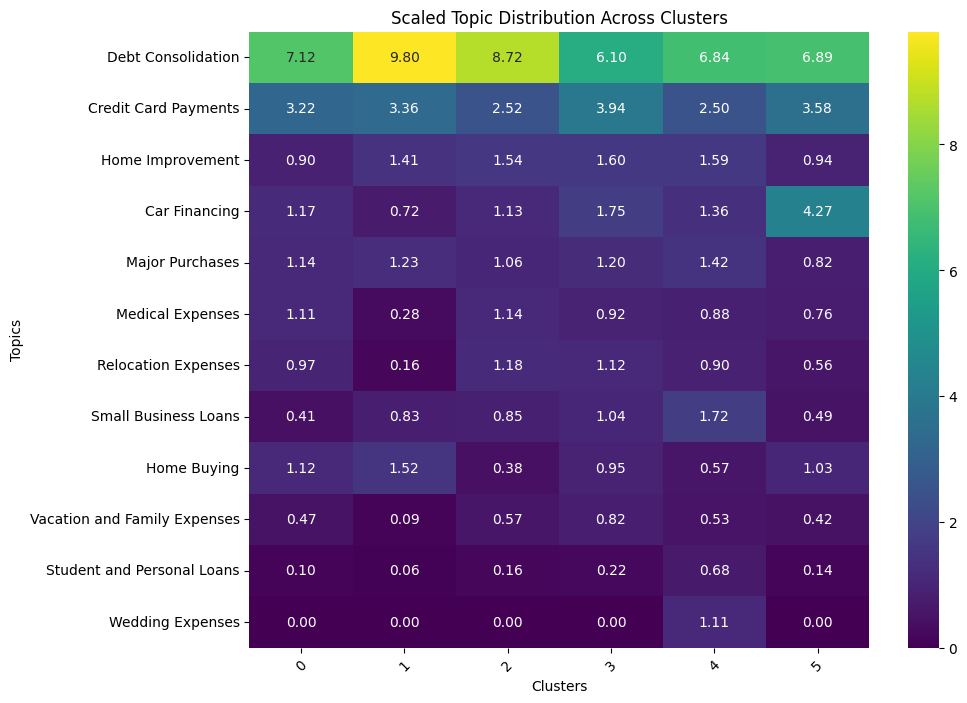

In [201]:
# Define the labeled topic columns
labeled_topic_columns = [
    'Debt Consolidation', 'Credit Card Payments', 'Home Improvement',
    'Car Financing', 'Major Purchases', 'Medical Expenses',
    'Relocation Expenses', 'Small Business Loans', 'Home Buying',
    'Vacation and Family Expenses', 'Student and Personal Loans', 'Wedding Expenses'
]

# Group by 'kmeans_cluster6' and calculate the mean for each topic
topic_cluster_distribution = data_test.groupby('kmeans_cluster6')[labeled_topic_columns].mean()

# Multiply by 1000 to amplify the small differences
topic_cluster_distribution_scaled = topic_cluster_distribution * 1000

# Create a heatmap of the scaled topic distribution across clusters
plt.figure(figsize=(10, 8))
sns.heatmap(topic_cluster_distribution_scaled.T, annot=True, cmap='viridis', fmt='.2f')
plt.title('Scaled Topic Distribution Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Topics')
plt.xticks(rotation=45)
plt.show()


Cluster 1 (9.80% Debt Consolidation, 3.36% Credit Card Payments): Most people in this group are applying for debt consolidation loans, which could mean they are struggling with their finances and trying to pay off or manage their debts. The credit card payments also show that they have a lot of debt to handle.

Cluster 2 (8.72% Debt Consolidation, 1.54% Home Improvement): This group has a lot of debt consolidation applications too, but also some loans for home improvements. People here might be trying to manage their debt while also working on home-related projects.

Cluster 5 (4.27% Car Financing, 6.89% Debt Consolidation): Many people in this group are applying for car financing, along with debt consolidation. They might be trying to buy or refinance their cars while dealing with high personal debt.

Cluster 4 (6.84% Debt Consolidation, 1.72% Small Business Loans): This group could include people trying to manage personal debt while also trying to grow or fund small businesses.

The heatmap shows that debt consolidation is a big reason for loan rejections, and applicants are often facing financial struggles in other areas like car financing and credit card payments.

## Conclusion : Take-away


Debt consolidation is the main reason in most clusters, showing that many people who are struggling with their finances are applying for loans but getting turned down.

High debt-to-income ratios and large loan amounts are big reasons for rejections, especially in clusters 1 and 5, where people are asking for large loans for things like car financing, home buying, or major purchases.

Loans for things like vacations, weddings, and small businesses are less common in the clusters, but still appear. People asking for these types of loans are likely being rejected because they are not seen as urgent compared to debt consolidation or car financing.